In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import plotly.express as px

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Loan_Default.csv')

In [21]:
# 2 Explore dataset

def explore_data(df):
    """Explore the DataFrame by displaying basic information and statistics."""
    print(df.info())
    print(df.describe())
    print(df.head())
    print(df.tail())
    print("DataFrame Shape:", df.shape)
    print("DataFrame Columns:", df.columns.tolist())

explore_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

Missing values before:
 Series([], dtype: int64)


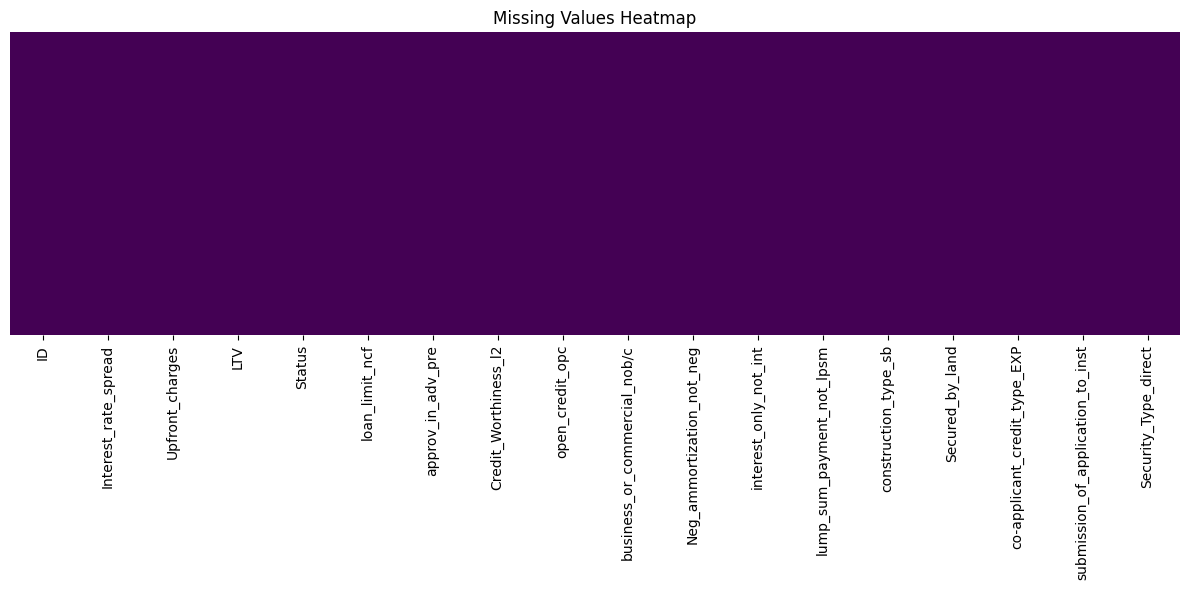

Missing values after:
 Series([], dtype: int64)
Dropped 0 low-value/missing columns: []
 Cleaned data saved to: /content/drive/MyDrive/Colab Notebooks/Cleaned_Loan_Default.csv
 Data Summary:
                   ID  Interest_rate_spread  Upfront_charges            LTV  \
count  148670.000000         148670.000000    148670.000000  148670.000000   
mean        0.500000              0.512288         0.366310       0.488527   
std         0.288678              0.235334         0.280611       0.200175   
min         0.000000              0.000000         0.000000       0.000000   
25%         0.250000              0.375000         0.159261       0.375000   
50%         0.500000              0.494099         0.330811       0.513137   
75%         0.750000              0.625000         0.495557       0.625000   
max         1.000000              1.000000         1.000000       1.000000   

              Status  
count  148670.000000  
mean        0.246445  
std         0.430942  
min         0

In [26]:

# 3️ Missing value inspection & filling
def find_missing_values(df):
    missing_values = df.isnull().sum()
    return missing_values[missing_values > 0]

print("Missing values before:\n", find_missing_values(df))

# 3.1 Heatmap of missing values
def plot_missing_values_heatmap(df):
    """Plot a heatmap showing missing values in the DataFrame."""
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.show()
plot_missing_values_heatmap(df)

def fill_missing_values(df):
    """Fill missing values with median for numeric and mode for categorical."""
    for col in df.columns:
        if df[col].dtype == 'object':
            fill_val = df[col].mode()[0]
        else:
            fill_val = df[col].median()
        df[col] = df[col].fillna(fill_val)

    return df

df = fill_missing_values(df)
print("Missing values after:\n", find_missing_values(df))

# 4️ Remove duplicates
df = df.drop_duplicates()

# 5️ Drop irrelevant columns (safe version)
def drop_irrelevant_columns(df, target='Status', missing_thresh=0.9, low_var_thresh=0.01):
    to_drop = []
    for col in df.columns:
        if col == target:
            continue
        missing_ratio = df[col].isnull().mean()
        if missing_ratio > missing_thresh:
            to_drop.append(col)
        elif df[col].nunique() <= 1:
            to_drop.append(col)
        elif df[col].nunique() / len(df) < low_var_thresh and df[col].nunique() > 2:
            to_drop.append(col)
    df.drop(columns=to_drop, inplace=True)
    print(f"Dropped {len(to_drop)} low-value/missing columns: {to_drop}")
    return df

df = drop_irrelevant_columns(df)

# 6️ Data type conversion
def convert_data_types(df):
    """Convert text to numeric or category as appropriate."""
    binary_map = {'Yes': 1, 'No': 0, 'Y': 1, 'N': 0, 'True': 1, 'False': 0}
    df.replace(binary_map, inplace=True)

    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() <= 20:
            df[col] = df[col].astype('category')

    # Ensure Status is int
    if 'Status' in df.columns:
        df['Status'] = pd.to_numeric(df['Status'], errors='coerce').fillna(0).astype(int)

    return df

df = convert_data_types(df)

# 7️ Encode categorical variables
def encode_categorical_variables(df, target='Status'):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [c for c in categorical_cols if c != target]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df

df = encode_categorical_variables(df)

# 8 Handle outliers (before scaling)
def remove_outliers(df, target='Status', iqr_factor=1.5):
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower, upper)  # Cap instead of remove
    return df

df = remove_outliers(df)

# 9 Scale numeric features (after outlier handling)
from sklearn.preprocessing import MinMaxScaler
def scale_numeric_features(df, target='Status'):
    scaler = MinMaxScaler()
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

df = scale_numeric_features(df)

# 10 Save cleaned data
def save_cleaned_data(df, filepath):
    df.to_csv(filepath, index=False)
    print(f" Cleaned data saved to: {filepath}")

save_cleaned_data(df, "/content/drive/MyDrive/Colab Notebooks/Cleaned_Loan_Default.csv")

# 11 Reload cleaned data
def load_cleaned_data(filepath):
    return pd.read_csv(filepath)

df = load_cleaned_data("/content/drive/MyDrive/Colab Notebooks/Cleaned_Loan_Default.csv")

# 12 Analyze cleaned data
def analyze_data(df):
    print(" Data Summary:\n", df.describe())
    print("\n Target Value Counts:\n", df['Status'].value_counts(normalize=True))
    print("\n Remaining Dtypes:\n", df.dtypes.value_counts())
    print("\n Final Shape:", df.shape)

analyze_data(df)



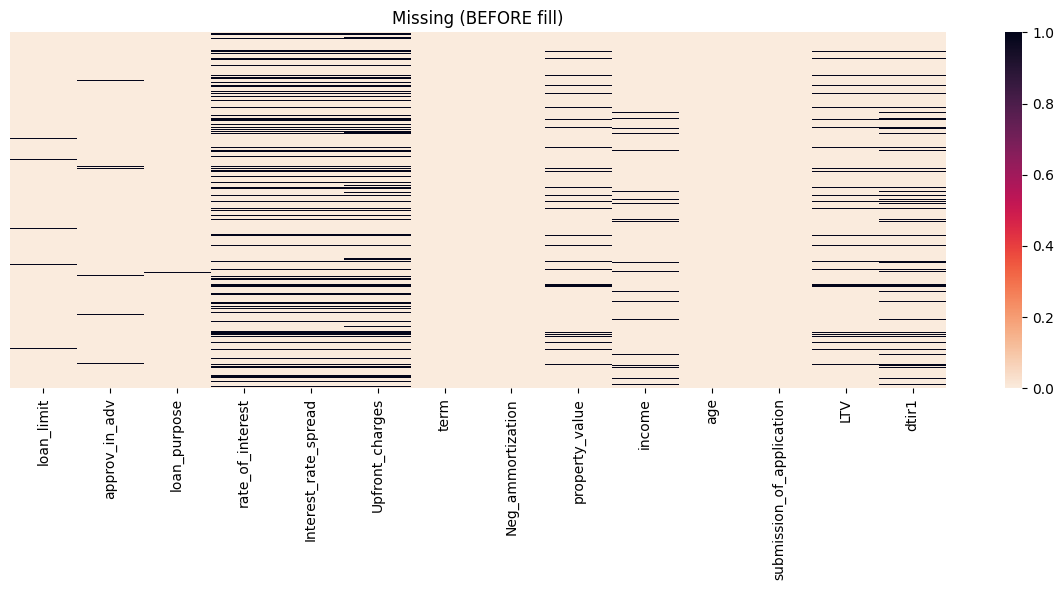

 No missing values to show.


In [28]:
# Load RAW once
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Loan_Default.csv')

def plot_missing_values_heatmap(df, title='Missing Values Heatmap'):
    na_cols = df.columns[df.isna().any()]
    if len(na_cols) == 0:
        print(" No missing values to show.")
        return
    plt.figure(figsize=(12, 6))
    sns.heatmap(df[na_cols].isna(), cbar=True, yticklabels=False, cmap='rocket_r', vmin=0, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# BEFORE imputation
plot_missing_values_heatmap(df_raw, title='Missing (BEFORE fill)')

df_clean = fill_missing_values(df_raw.copy())

# AFTER imputation
plot_missing_values_heatmap(df_clean, title='Missing (AFTER fill)')


Numeric Summary Statistics:
                   ID  Interest_rate_spread  Upfront_charges            LTV  \
count  148670.000000         148670.000000    148670.000000  148670.000000   
mean        0.500000              0.512288         0.366310       0.488527   
std         0.288678              0.235334         0.280611       0.200175   
min         0.000000              0.000000         0.000000       0.000000   
25%         0.250000              0.375000         0.159261       0.375000   
50%         0.500000              0.494099         0.330811       0.513137   
75%         0.750000              0.625000         0.495557       0.625000   
max         1.000000              1.000000         1.000000       1.000000   

              Status  
count  148670.000000  
mean        0.246445  
std         0.430942  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


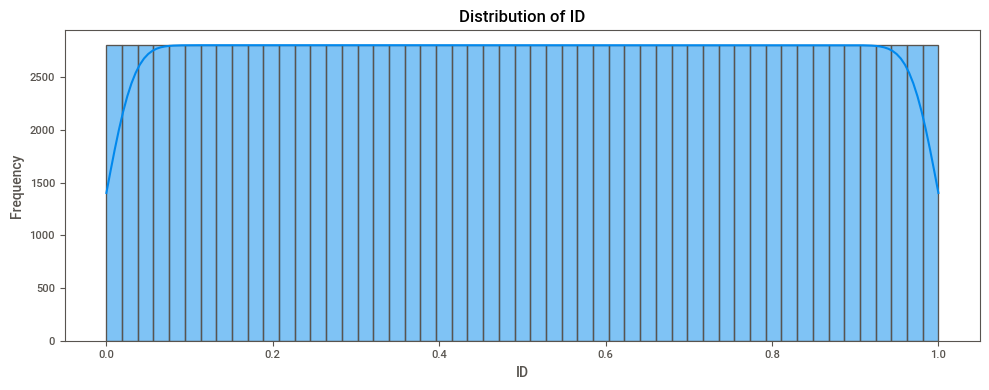

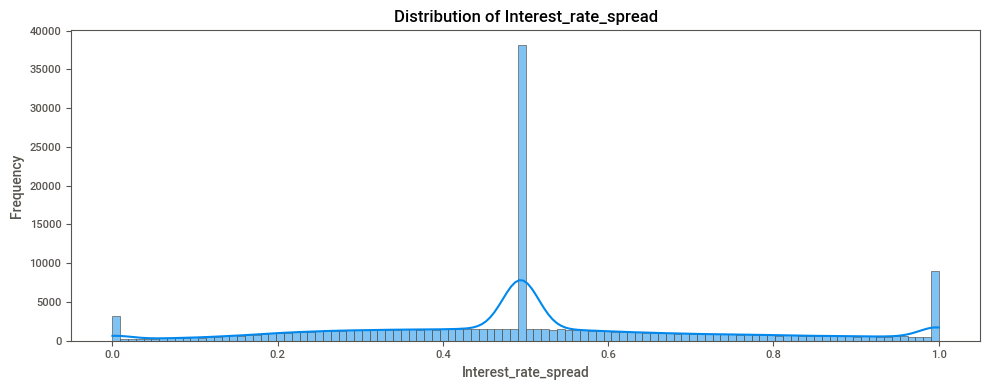

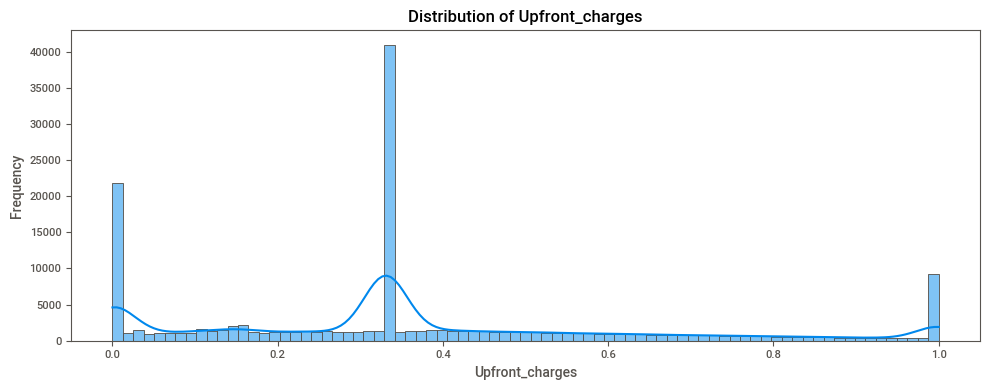

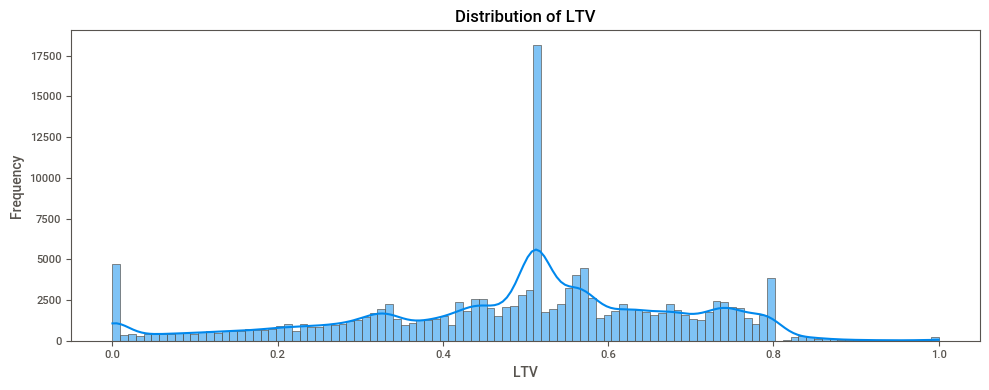

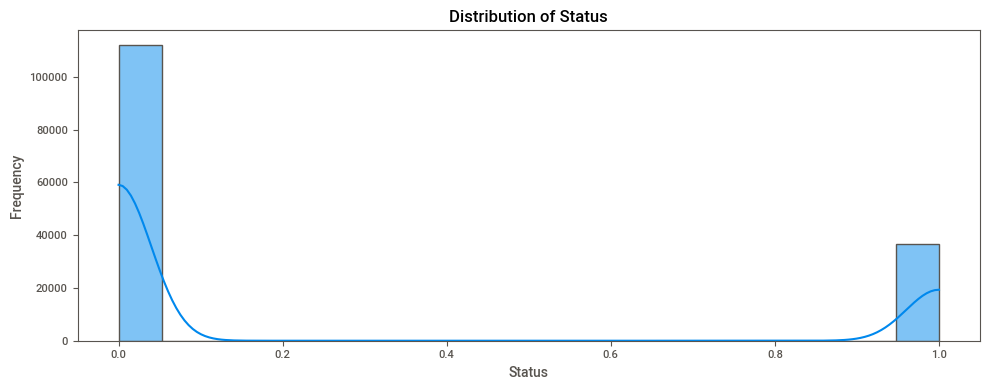

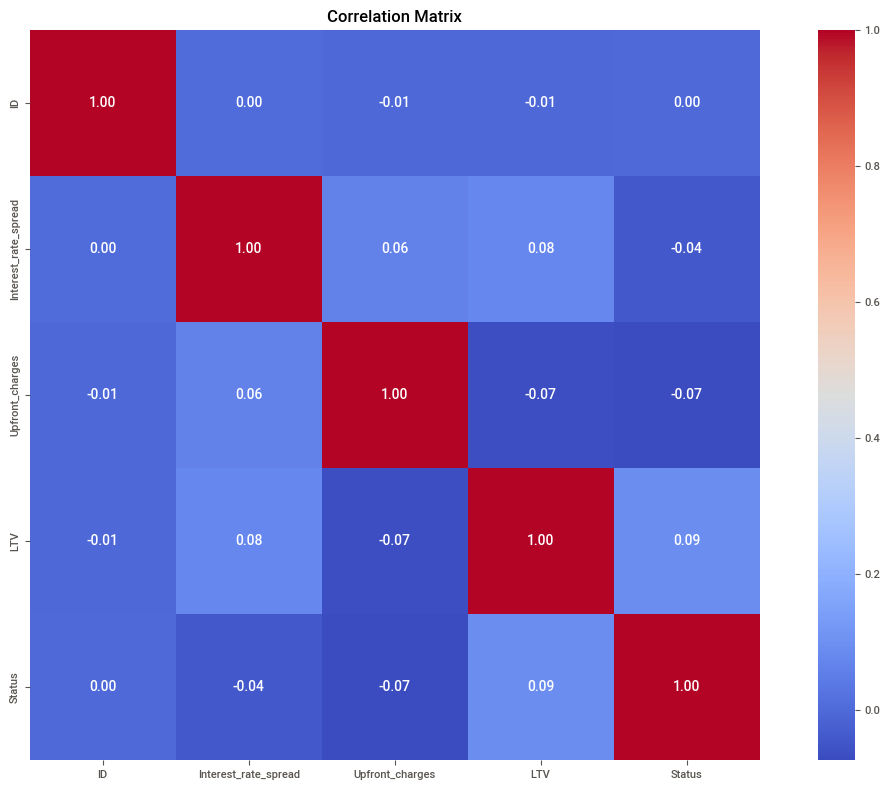

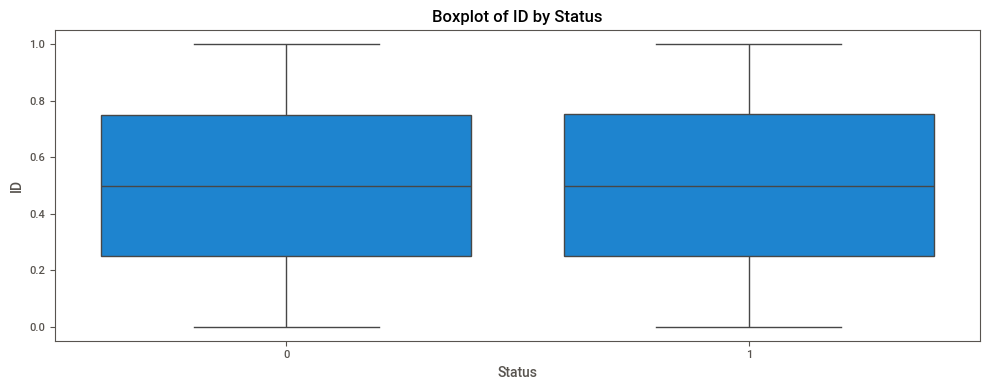

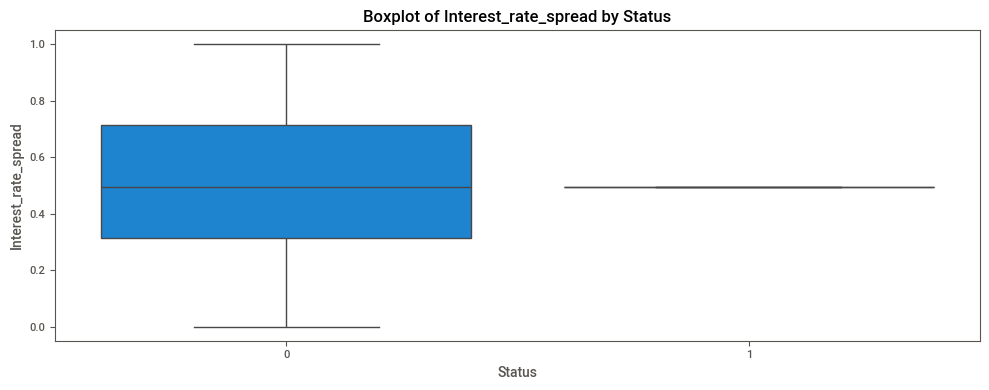

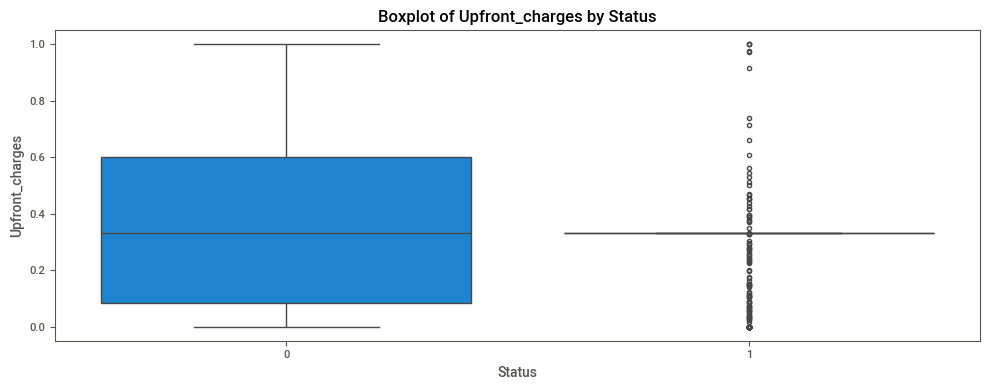

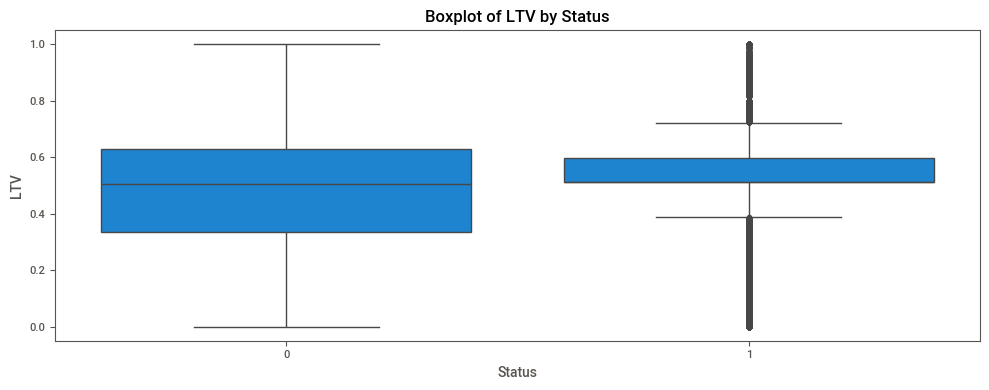

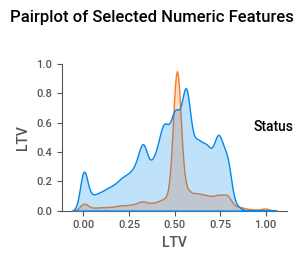

 Visualizations saved as image files.
 No categorical columns found (likely after encoding).
 Summary statistics exported: numeric_summary.csv, categorical_summary.csv


In [35]:

# Visualize cleaned data

# 13 Numeric Summarystatistics
def numeric_summary(df):
    """Return summary statistics for numeric columns in the DataFrame."""
    numeric_cols = df.select_dtypes(include=[np.number])
    return numeric_cols.describe()
numeric_stats = numeric_summary(df)
print("Numeric Summary Statistics:\n", numeric_stats)

# 14 Categorical Summary statistics
def categorical_summary(df, verbose=True):
    """Return summary stats for categorical columns; handle none-present case."""
    cats = df.select_dtypes(include=['object', 'category'])
    if cats.shape[1] == 0:
        if verbose:
            print(" No categorical columns found (likely after encoding).")
        # Return empty DataFrame to avoid ValueError
        return pd.DataFrame(columns=["count","unique","top","freq"])
    summary = cats.describe()
    if verbose:
        print("Categorical Summary Statistics:\n", summary)
    return summary


# 15 Plot distributions for numeric columns
def plot_distributions(df):
    """Plot distributions for numeric columns in the DataFrame."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
plot_distributions(df)

# 16 Plot count plots for categorical columns
def plot_categorical_counts(df):
    """Plot count plots for categorical columns in the DataFrame."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Count Plot of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
plot_categorical_counts(df)

# 17 Correlation matrix for numeric columns
def correlation_matrix(df):
    """Plot the correlation matrix for numeric columns in the DataFrame."""
    numeric_cols = df.select_dtypes(include=[np.number])
    corr = numeric_cols.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
correlation_matrix(df)

# 18 Status vs numeric features(Boxplots)
def plot_box_by_target(df, target='Status'):
    """Plot boxplots of numeric features grouped by the target variable."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[target], y=df[col])
        plt.title(f'Boxplot of {col} by {target}')
        plt.xlabel(target)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
plot_box_by_target(df)

# 19 Pairplot of numeric features
def plot_pairplot(df, target='Status'):
    """Plot pairplot of numeric features colored by the target variable."""
    top_cols = ['loan_amount', 'rate_of_interest', 'LTV','income', target]
    existing = [col for col in top_cols if col in df.columns]
    if len(existing) >= 2:
        sns.pairplot(df[existing], hue=target, diag_kind='kde')
        plt.suptitle('Pairplot of Selected Numeric Features', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numeric columns for pairplot.")
plot_pairplot(df)

# 20 interactive plots with plotly
import plotly.express as px
def interactive_scatter_plot(df, x, y, color=None):
    """Create an interactive scatter plot using Plotly."""
    if 'loan_amount' in df.columns and 'income' in df.columns:
        fig = px.scatter(df, x=x, y=y, color=color, title=f'Interactive Scatter Plot of {y} vs {x}')
        fig.show()
    if 'rate_of_interest' in df.columns and 'LTV' in df.columns:
        fig = px.scatter(df, x='rate_of_interest', y='LTV', color=color, title='Interactive Scatter Plot of LTV vs Rate of Interest')
        fig.show()
    if 'loan_amount' in df.columns and 'Status' in df.columns:
        fig = px.histogram(df, x='loan_amount', color=color, title='Interactive Histogram of Loan Amount by Status', barmode='group')
        fig.show()
    if 'rate_of_interest' in df.columns and 'Status' in df.columns:
        fig = px.histogram(df, x='rate_of_interest', color=color, title='Interactive Histogram of Rate of Interest by Status', barmode='group')
        fig.show()
    if 'rate_of_interest' in df.columns and 'income' in df.columns:
        fig = px.box(df, x=color, y='rate_of_interest', title='Interactive Box Plot of Rate of Interest by Status')
        fig.show()
interactive_scatter_plot(df, x='loan_amount', y='income', color='Status')


# 21 Save visualizations
def save_visualizations(df):
    """Save key visualizations as image files."""
    # Example: Save correlation matrix
    numeric_cols = df.select_dtypes(include=[np.number])
    corr = numeric_cols.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig("correlation_matrix.png")
    plt.close()
    print(" Visualizations saved as image files.")
save_visualizations(df)

# 22 Export summary statistics
def export_summary_statistics(df, numeric_file='numeric_summary.csv', categorical_file='categorical_summary.csv'):
    """Export summary statistics to CSV files."""
    numeric_stats = numeric_summary(df)
    numeric_stats.to_csv(numeric_file)
    categorical_stats = categorical_summary(df)
    categorical_stats.to_csv(categorical_file)
    print(f" Summary statistics exported: {numeric_file}, {categorical_file}")
export_summary_statistics(df)